In [ ]:
%%capture
!pip install gensim

In [ ]:
!tar -xzvf "/content/drive/MyDrive/HUS 2025-26/NLP/data/hwu.tar.gz"

hwu/
hwu/categories.json
hwu/train_5.csv
hwu/train_10.csv
hwu/val.csv
hwu/test.csv
hwu/train.csv


In [ ]:
import pandas as pd

df_train = pd.read_csv('hwu/train.csv')
df_val   = pd.read_csv('hwu/val.csv')
df_test  = pd.read_csv('hwu/test.csv')

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (8954, 2)
Validation shape: (1076, 2)
Test shape: (1076, 2)


,text,category
0,what alarms do i have set right now,alarm_query
1,checkout today alarm of meeting,alarm_query
2,report alarm settings,alarm_query
3,see see for me the alarms that you have set to...,alarm_query
4,is there an alarm for ten am,alarm_query


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Đổi tên cột
df_train = df_train.rename(columns={'category': 'intent'})
df_val   = df_val.rename(columns={'category': 'intent'})
df_test  = df_test.rename(columns={'category': 'intent'})

# 2. Mã hoá nhãn intent
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([df_train['intent'], df_val['intent'], df_test['intent']]))

y_train = label_encoder.transform(df_train['intent'])
y_val   = label_encoder.transform(df_val['intent'])
y_test  = label_encoder.transform(df_test['intent'])

num_classes = len(label_encoder.classes_)
print("Số lớp:", num_classes)
print("Ví dụ nhãn mã hoá:", list(set(zip(df_train['intent'], y_train)))[:10])


Số lớp: 64
Ví dụ nhãn mã hoá: [('play_podcasts', np.int64(45)), ('recommendation_events', np.int64(52)), ('general_commandstop', np.int64(17)), ('play_music', np.int64(44)), ('email_query', np.int64(13)), ('music_query', np.int64(39)), ('recommendation_locations', np.int64(53)), ('play_audiobook', np.int64(42)), ('alarm_query', np.int64(0)), ('general_negate', np.int64(22))]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_val, X_test = df_train['text'], df_val['text'], df_test['text']

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alarm_query       0.90      0.95      0.92        19
            alarm_remove       1.00      0.73      0.84        11
               alarm_set       0.77      0.89      0.83        19
       audio_volume_down       1.00      0.75      0.86         8
       audio_volume_mute       0.92      0.80      0.86        15
         audio_volume_up       0.93      1.00      0.96        13
          calendar_query       0.45      0.53      0.49        19
         calendar_remove       0.89      0.89      0.89        19
            calendar_set       0.87      0.68      0.76        19
          cooking_recipe       0.59      0.68      0.63        19
        datetime_convert       0.67      0.75      0.71         8
          datetime_query       0.74      0.89      0.81        19
        email_addcontact       0.78      0.88      0.82         8
             email_query       0.83      0.79      0.81        19
      ema

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.0170 - loss: 4.1686 - val_accuracy: 0.0177 - val_loss: 4.1228
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0270 - loss: 4.1258 - val_accuracy: 0.0455 - val_loss: 4.1037
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0370 - loss: 4.1088 - val_accuracy: 0.0632 - val_loss: 4.0859
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0508 - loss: 4.0889 - val_accuracy: 0.0725 - val_loss: 4.0611
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0580 - loss: 4.0617 - val_accuracy: 0.0725 - val_loss: 4.0240
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0641 - loss: 4.0202 - val_accuracy: 0.0660 - val_loss: 3.9759
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0650 - loss: 3.9676 - val_accuracy: 0.0911 - val_loss: 3.9150
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0744 - loss: 3.9173 - val_accuracy: 0.0901 - 

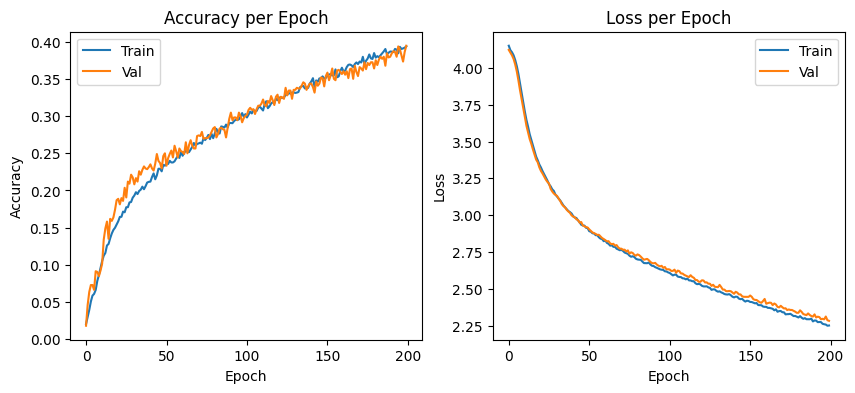

In [ ]:
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


sentences = [t.split() for t in df_train['text']]
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def sentence_to_avg_vector(text, model):
    tokens = text.split()
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

X_train_avg = np.array([sentence_to_avg_vector(t, w2v) for t in df_train['text']])
X_val_avg   = np.array([sentence_to_avg_vector(t, w2v) for t in df_val['text']])
X_test_avg  = np.array([sentence_to_avg_vector(t, w2v) for t in df_test['text']])

y_train_oh, y_val_oh, y_test_oh = map(to_categorical, [y_train, y_val, y_test])

model = Sequential([
    Dense(128, activation='relu', input_shape=(w2v.vector_size,)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(X_train_avg, y_train_oh, validation_data=(X_val_avg, y_val_oh), epochs=200, batch_size=256, callbacks=callbacks)

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.0184 - loss: 4.1551 - val_accuracy: 0.0223 - val_loss: 4.1227
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0194 - loss: 4.1287 - val_accuracy: 0.0372 - val_loss: 4.0691
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0293 - loss: 4.0690 - val_accuracy: 0.0437 - val_loss: 3.9875
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0382 - loss: 4.0026 - val_accuracy: 0.0511 - val_loss: 3.8996
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0504 - loss: 3.8887 - val_accuracy: 0.0548 - val_loss: 3.8363
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0535 - loss: 3.8560 - val_accuracy: 0.0660 - val_loss: 3.7566
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0581 - loss: 3.7890 - val_accuracy: 0.0632 - val_loss: 3.6755
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0689 - loss: 3.7100 - val_accuracy: 0.0753 - val_l

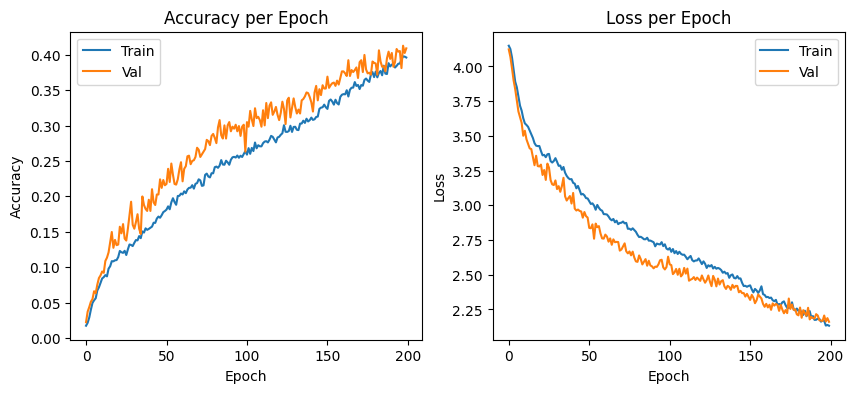

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(df_train['text'])
vocab_size = len(tokenizer.word_index) + 1

def seq_pad(texts, max_len=50):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=max_len, padding='post')

max_len = 50
X_train_pad = seq_pad(df_train['text'], max_len)
X_val_pad   = seq_pad(df_val['text'], max_len)
X_test_pad  = seq_pad(df_test['text'], max_len)

# --- Ma trận embedding từ Word2Vec ---
embedding_dim = w2v.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]

model_pretrained = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0),
    Dense(num_classes, activation='softmax')
])

model_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

history = model_pretrained.fit(X_train_pad, y_train_oh, validation_data=(X_val_pad, y_val_oh),
                     epochs=200, batch_size=256, callbacks=callbacks)

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0164 - loss: 4.1521 - val_accuracy: 0.0177 - val_loss: 4.1277
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0200 - loss: 4.1333 - val_accuracy: 0.0177 - val_loss: 4.1257
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0182 - loss: 4.1333 - val_accuracy: 0.0177 - val_loss: 4.1260
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0144 - loss: 4.1315 - val_accuracy: 0.0177 - val_loss: 4.1248
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0121 - loss: 4.1284 - val_accuracy: 0.0177 - val_loss: 4.1255
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0189 - loss: 4.1295 - val_accuracy: 0.0177 - val_loss: 4.1248
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0152 - loss: 4.1262 - val_accuracy: 0.0177 - val_loss: 4.1252
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0164 - loss: 4.1326 - val_accuracy: 0.

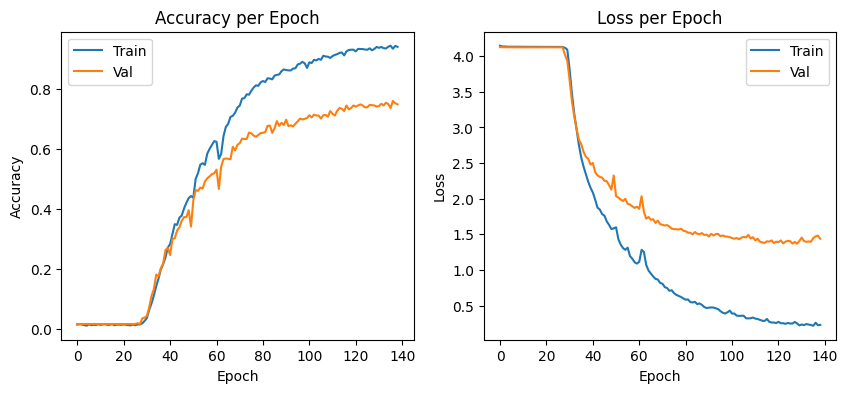

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(df_train['text'])
vocab_size = len(tokenizer.word_index) + 1

def seq_pad(texts, max_len=50):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=max_len, padding='post')

max_len = 50
X_train_pad = seq_pad(df_train['text'], max_len)
X_val_pad   = seq_pad(df_val['text'], max_len)
X_test_pad  = seq_pad(df_test['text'], max_len)

# --- Ma trận embedding từ Word2Vec ---
embedding_dim = w2v.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]

model_pretrained = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=True),
    LSTM(128, dropout=0.3, recurrent_dropout=0),
    Dense(num_classes, activation='softmax')
])

model_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model_pretrained.fit(X_train_pad, y_train_oh, validation_data=(X_val_pad, y_val_oh),
                     epochs=200, batch_size=256, callbacks=callbacks)

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model_pretrained.summary()
